In [2]:
import numpy as np

# Load all prediction/label arrays
xgb_preds  = np.load("predictions/XGB_Smote_preds.npy")
xgb_labels = np.load("predictions/XGB_Smote_labels.npy")

lstm_preds  = np.load("predictions/LSTM+ATTENTION_preds.npy")
lstm_labels = np.load("predictions/LSTM+ATTENTION_labels.npy")

cng_preds  = np.load("predictions/CNG+LSTM_preds.npy")
cng_labels = np.load("predictions/CNG+LSTM_labels.npy")

gnn_preds  = np.load("predictions/GCN_preds.npy")
gnn_labels = np.load("predictions/GCN_labels.npy")

svm_preds  = np.load("predictions/Autoencoder_SVM_preds.npy")
svm_labels = np.load("predictions/Autoencoder_SVM_labels.npy")

# 🔄 Truncate all to the minimum common length
min_len = min(map(len, [xgb_preds, lstm_preds, cng_preds, gnn_preds, svm_preds]))

xgb_preds = xgb_preds[:min_len]
lstm_preds = lstm_preds[:min_len]
cng_preds = cng_preds[:min_len]
gnn_preds = gnn_preds[:min_len]
svm_preds = svm_preds[:min_len]

# Also align labels
meta_labels = xgb_labels[:min_len]  # Use XGB labels as canonical set

print(f"✅ Aligned all predictions to common length: {min_len}")


✅ Aligned all predictions to common length: 849


In [3]:
from sklearn.model_selection import train_test_split

# 🔧 Stack predictions into meta-feature matrix (N_samples, N_models)
meta_features = np.vstack([
    xgb_preds,
    lstm_preds,
    cng_preds,
    gnn_preds,
    svm_preds
]).T

print("🧩 Meta-feature matrix shape:", meta_features.shape)

# 🎯 Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    meta_features, meta_labels, test_size=0.3, stratify=meta_labels, random_state=42
)

print(f"✅ Train shape: {X_train.shape}, Test shape: {X_test.shape}")


🧩 Meta-feature matrix shape: (849, 5)
✅ Train shape: (594, 5), Test shape: (255, 5)


📋 Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.96      0.98       195
           1       0.89      0.98      0.94        60

    accuracy                           0.97       255
   macro avg       0.94      0.97      0.96       255
weighted avg       0.97      0.97      0.97       255

🔥 ROC AUC Score: 0.975


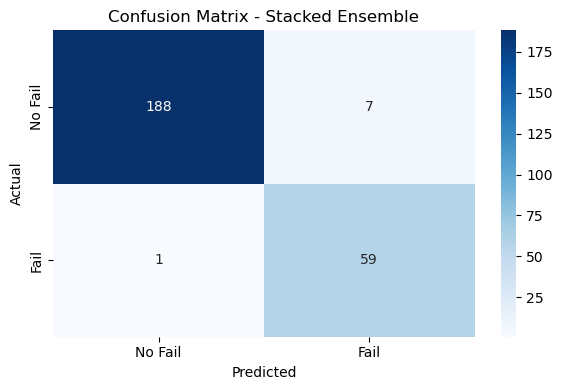

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import os

# 🧠 Train meta-classifier
meta_model = RandomForestClassifier(n_estimators=200, random_state=42)
meta_model.fit(X_train, y_train)

# 🔍 Predict
y_pred = meta_model.predict(X_test)
y_prob = meta_model.predict_proba(X_test)[:, 1]

# 📊 Evaluation
print("📋 Classification Report:")
print(classification_report(y_test, y_pred))

roc = roc_auc_score(y_test, y_prob)
print(f"🔥 ROC AUC Score: {roc:.3f}")

# 📉 Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Fail", "Fail"], yticklabels=["No Fail", "Fail"])
plt.title("Confusion Matrix - Stacked Ensemble")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()

os.makedirs("visualization", exist_ok=True)
plt.savefig("visualization/stacked_ensemble_confusion_matrix.png")
plt.show()


In [7]:
import shap
import matplotlib.pyplot as plt
import os

# Assign readable feature names
feature_names = ["XGB+SMOTE", "LSTM+Attention", "CNG+LSTM", "GCN", "AutoEnc+SVM"]

print("X_train shape:", X_train.shape)
print("Feature names count:", len(feature_names))


X_train shape: (594, 5)
Feature names count: 5


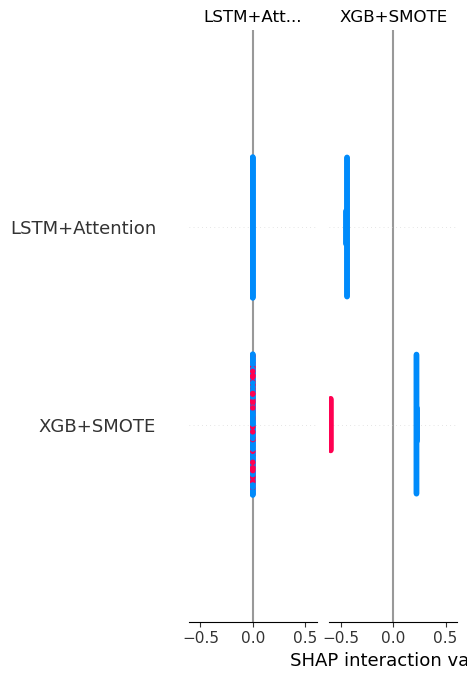

<Figure size 1600x1600 with 0 Axes>

In [16]:
import shap
import numpy as np
import os
import matplotlib.pyplot as plt

# Feature names
feature_names = np.array(["XGB+SMOTE", "LSTM+Attention", "CNG+LSTM", "GCN", "AutoEnc+SVM"])

# SHAP Explainer
explainer = shap.Explainer(meta_model, X_train, feature_names=feature_names)
shap_values = explainer(X_test)

# Summary plot (bar-style)
shap.summary_plot(shap_values.values, X_test, feature_names=feature_names, plot_type="bar")

# Save
os.makedirs("visualization", exist_ok=True)
plt.gcf().set_size_inches(16, 16)
plt.savefig("visualization/stacked_ensemble_shap_summary_bar.png", bbox_inches='tight')
plt.show()


TypeError: only integer scalar arrays can be converted to a scalar index

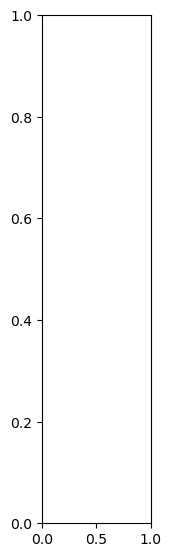

In [19]:
import shap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Named feature columns
feature_names = np.array(["XGB+SMOTE", "LSTM+Attention", "CNG+LSTM", "GCN", "AutoEnc+SVM"])
X_train_df = pd.DataFrame(X_train, columns=feature_names)
X_test_df = pd.DataFrame(X_test, columns=feature_names)

# Explainer
explainer = shap.Explainer(meta_model, X_train_df)
shap_values = explainer(X_test_df)

# ✅ Bar summary plot
shap.summary_plot(shap_values, X_test_df, plot_type="bar")

# 💾 Save
os.makedirs("visualization", exist_ok=True)
plt.savefig("visualization/stacked_ensemble_shap_summary.png", bbox_inches="tight")
plt.show()
